In [ ]:
# citation:
# https://github.com/goutham-fin/PrincetonECO529/blob/main/Lecture%20note%20chapters/Chapter%204.ipynb

# Setup

In [5]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from deep_macrofin import PDEModel
from deep_macrofin import ActivationType, Comparator, Constraint, EndogVar, EndogVarConditions, EndogEquation, System, OptimizerType, plot_loss_df,  set_seeds, SamplingMethod
torch.set_default_dtype(torch.float32) # try this differently
import pandas as pd

In [6]:
# latex variable mapping supported directly!
latex_variable_mapping = {
    r"\eta": "eta",
    r"q": "q",
    r"\kappa": "kappa",
    r"\sigma^q": "sigma_q",
    r"\iota": "iota",
    r"\rho^e": "rho_e",
    r"\rho^h": "rho_h",
    r"\delta": "delta",
    r"A^e": "a_e",
    r"A^h": "a_h",
    r"\sigma": "sigma",
    r"\phi": "phi"
}

In [7]:
parameter_dict = {
    "rho_e": 0.06, 
    "rho_h": 0.04, 
    "delta": 0.05, 
    "a_e": 0.11,
    "a_h": 0.07,
    "sigma": 0.10,
    "phi": 10,
}

In [8]:
# we solve kappa = 1, kappa < 1 separately (Goutham's notebook)

In [9]:
batch_size = 1000
set_seeds(7)
pdem_unc = PDEModel(name = "two_a_one_q", latex_var_mapping = latex_variable_mapping,
                             config={"samplinng_method": SamplingMethod.FixedGrid,
                                    "batch_size": batch_size,
                                    "num_epochs": 30000,
                                    "optimizer_type": OptimizerType.Adam})


In [10]:
# state variable
pdem_unc.set_state(["eta"], {"eta": [0.001, 0.999]})

In [11]:
# "learnable" variables, aka "endogenous" (determined by system)
pdem_unc.add_endogs(names=["q", "sigma_q"],
                   configs={
                       "q": {"positive": True, "activation_type": ActivationType.Tanh},
                       #"kappa": {"positive": True, "activation_type": ActivationType.Tanh},
                       "sigma_q": {"postive": False, "activation_type": ActivationType.Tanh}
                   })

# note that sigma_q can of course be negative (means dq moves the opposite way as dW_t)

In [12]:
# parameters (that will shortly appear in equations)
pdem_unc.add_params(parameter_dict)

In [13]:
# boundary conditions for endogenous variables. Need "SV"
# latex isn't implemented here yet, sadly
pdem_unc.add_endog_condition(
    name="q",
    lhs="q(SV)",
    lhs_state={"SV": torch.zeros((1, 1))},
    comparator=Comparator.EQ,  # can use inequalities also!!
    rhs="(phi* a_h + 1) / (phi * rho_h + 1)",  # see if latex works
    rhs_state = pdem_unc.variable_val_dict,  # it knows what to fill 
    label="q_eta0",
    weight=batch_size / 10) # follow default weights for now

pdem_unc.add_endog_condition(
    name="q",
    lhs="q(SV)",
    lhs_state={"SV": torch.ones((1, 1))},
    comparator=Comparator.EQ,  # can use inequalities also!!
    rhs="(phi* a_e + 1) / (phi * rho_e + 1)",  # see if latex works
    rhs_state = pdem_unc.variable_val_dict,  # it knows what to fill 
    label="q_eta1",
    weight=batch_size / 10) # follow default weights for now

# pdem_unc.add_endog_condition(
#     name="kappa",
#     lhs="kappa(state)",
#     lhs_state={"state": torch.zeros((1, 1))},
#     comparator=Comparator.EQ,  # can use inequalities also!!
#     rhs="0",  # see if latex works
#     rhs_state = pdem_unc.variable_val_dict,
#     label="kappa_eta0",
#     weight=batch_size / 10) # follow default weights for now

# pdem_unc.add_endog_condition(
#     name="kappa",
#     lhs="kappa(state)",
#     lhs_state={"state": torch.ones((1, 1))},
#     comparator=Comparator.EQ,  # can use inequalities also!!
#     rhs="1",  # see if latex works
#     rhs_state = pdem_unc.variable_val_dict,
#     label="kappa_eta1",
#     weight=batch_size / 10) # follow default weights for now

pdem_unc.add_endog_condition(
    name="sigma_q",
    lhs="sigma_q(state)",
    lhs_state={"state": torch.zeros((1, 1))},
    comparator=Comparator.EQ,  # can use inequalities also!!
    rhs="0",  # see if latex works
    rhs_state = pdem_unc.variable_val_dict,
    label="sigma_q_eta0",
    weight=batch_size / 10) # follow default weights for now


pdem_unc.add_endog_condition(
    name="sigma_q",
    lhs="sigma_q(state)",
    lhs_state={"state": torch.ones((1, 1))},
    comparator=Comparator.EQ,  # can use inequalities also!!
    rhs="0",  # see if latex works
    rhs_state = pdem_unc.variable_val_dict,
    label="sigma_q_eta1",
    weight=batch_size / 10) # follow default weights for now

In [14]:
# learnable variable equations. must add "*" for multiplication and use r"" for latex
# weight is extremely important, otherwise default weights the mse of all points for this equation to 1
# guessing we need partial derivative notation
pdem_unc.add_endog_equation(r"$\eta*(1-\eta)*\left(A^e - A^h\right) = q* (\kappa - \eta)*(\sigma + \sigma^q)^2$", weight = batch_size * 2)
pdem_unc.add_endog_equation(r"$(\sigma + \sigma^q)* \frac{\partial q}{\partial \eta}*(\kappa - \eta) = \sigma^q *q$", weight = batch_size)

In [15]:
# add constraining equations to define the other variables
pdem_unc.add_equation(r"$\iota = \frac{1}{\phi}*(q -1)$")
pdem_unc.add_equation(r"$\kappa = \frac{\iota - A^h + (\eta *\rho^e + (1-\eta)*\rho^h)*q}{A^e - A^h}$")

In [16]:
# train

In [17]:
pdem_unc.train_model("./deep_macrofin_training/", "2a1q.pt", True)

====================================Training====================================


Min loss: 0.0011: 100%|███████████████████| 30000/30000 [14:43<00:00, 33.95it/s]

training finished, total time :: 883.6389780044556
Best model saved to ./deep_macrofin_training//2a1q_best.pt if valid
Model saved to ./deep_macrofin_training//2a1q.pt


OrderedDict([('endogvar_q_cond_q_eta0',
              tensor(3.4406e-08, grad_fn=<MeanBackward0>)),
             ('endogvar_q_cond_q_eta1',
              tensor(1.1768e-10, grad_fn=<MeanBackward0>)),
             ('endogvar_sigma_q_cond_sigma_q_eta0',
              tensor(2.4182e-07, grad_fn=<MeanBackward0>)),
             ('endogvar_sigma_q_cond_sigma_q_eta1',
              tensor(1.7202e-07, grad_fn=<MeanBackward0>)),
             ('endogeq_1', tensor(5.2891e-07, grad_fn=<MeanBackward0>)),
             ('endogeq_2', tensor(1.0056e-07, grad_fn=<MeanBackward0>)),
             ('total_loss', tensor(0.0012, grad_fn=<AddBackward0>))])

Model loaded
===================================Evaluating===================================
loss :: endogvar_q_cond_q_eta0: 0.0000,
endogvar_q_cond_q_eta1: 0.0000,
endogvar_sigma_q_cond_sigma_q_eta0: 0.0000,
endogvar_sigma_q_cond_sigma_q_eta1: 0.0000,
endogeq_1: 0.0000,
endogeq_2: 0.0000,
total_loss: 0.0012


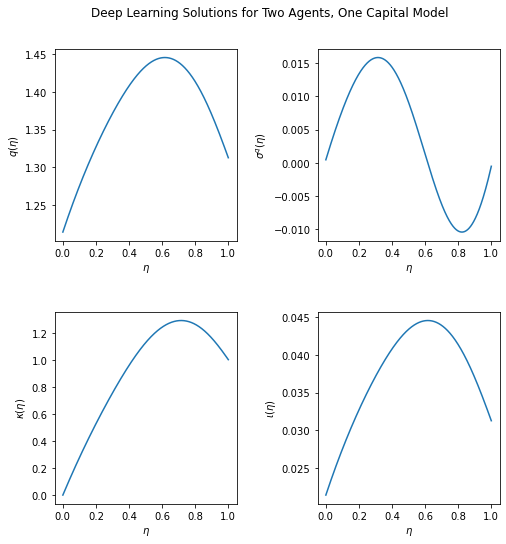

In [31]:
# load model and get sols
pdem_unc.load_model(torch.load("./deep_macrofin_training/2a1q.pt"))
pdem_unc.eval_model(True)
eta = torch.linspace(0, 1, 1001).reshape(-1, 1) # must be a pytorch input
q_sol = pdem_unc.endog_vars["q"](eta).detach().cpu().numpy().reshape(-1) # computes sols given state var input
sigma_q_sol = pdem_unc.endog_vars["sigma_q"](eta).detach().cpu().numpy().reshape(-1)


globals().update(parameter_dict)
# (rho_e, rho_h, a_e, a_h, sigma, phi) = (parameter_dict["rho_e"],
#                                                parameter_dict["rho_h"],
#                                                parameter_dict["a_e"],
#                                                parameter_dict["a_h"],
#                                                parameter_dict["sigma"],
#                                                parameter_dict["phi"])

eta = eta.numpy().reshape(-1)
iota_sol = (q_sol - 1) / phi
eta*rho_e + (1-eta) * rho_h
kappa_sol = (iota_sol - a_h + (eta * rho_e + (1-eta) * rho_h) * q_sol) / (a_e - a_h)

fig, axs = plt.subplots(2, 2, figsize=(8, 8))
fig.tight_layout(pad = 5.0)
axs = axs.flatten()
axs[0].plot(eta, q_sol)
axs[0].set_xlabel(r"$\eta$")
axs[0].set_ylabel(r"$q(\eta)$")
axs[1].plot(eta, sigma_q_sol)
axs[1].set_xlabel(r"$\eta$")
axs[1].set_ylabel(r"$\sigma^q(\eta)$")
axs[2].plot(eta, kappa_sol)
axs[2].set_xlabel(r"$\eta$")
axs[2].set_ylabel(r"$\kappa (\eta)$")
axs[3].plot(eta, iota_sol)
axs[3].set_xlabel(r"$\eta$")
axs[3].set_ylabel(r"$\iota (\eta)$")
plt.suptitle("Deep Learning Solutions for Two Agents, One Capital Model")
plt.show()



In [32]:
# debug
loss_file = pd.read_csv("./deep_macrofin_training/2a1q_loss.csv")
loss_file.tail(3)

,epoch,endogvar_q_cond_q_eta0,endogvar_q_cond_q_eta1,endogvar_sigma_q_cond_sigma_q_eta0,endogvar_sigma_q_cond_sigma_q_eta1,endogeq_1,endogeq_2,total_loss
297,29700,3.125834e-09,2.664379e-07,3.683797e-09,8.290409e-07,5.287806e-07,5.373273e-07,0.001705
298,29800,2.036144e-06,3.654824e-06,3.288265e-09,5.023180e-07,4.761550e-07,6.402511e-07,0.002212
299,29900,5.741327e-10,6.312778e-07,3.064103e-08,5.781028e-08,5.190233e-07,2.478286e-07,0.001358


In [20]:
# constrained regime:
kappa = 1
q = (phi * a_e + 1) / (phi * (rho_h + eta * (rho_e - rho_h)) + 1)
q_pr = -(phi * a_e + 1) * (phi* (rho_e - rho_h)) / (phi * (rho_h + eta * (rho_e - rho_h)) + 1) ** 2
sigma_q = sigma * q_pr * (1 - eta) / (q - q_pr * (1 - eta))
iota = (q - 1) / phi

In [21]:
# merge regimes
# trick from Goutham: use indicators
constrained = (kappa_sol >= 1)
unconstrained = 1 - constrained
q_merged = unconstrained * q_sol + constrained * q
sigma_q_merged = unconstrained * sigma_q_sol + constrained * sigma_q
kappa_merged = unconstrained * kappa_sol + constrained * kappa
iota_merged = unconstrained * iota_sol + constrained * iota

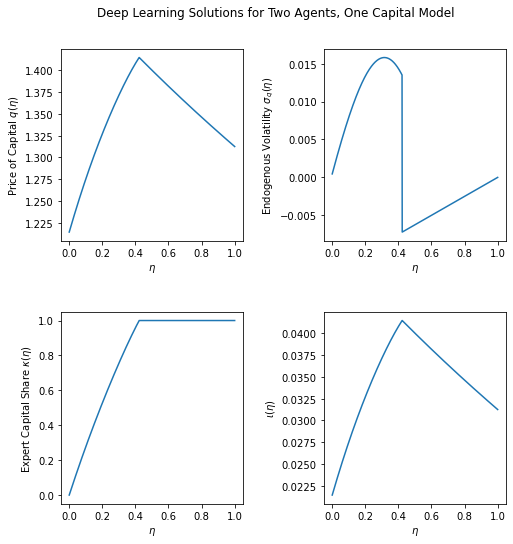

In [22]:
# full results
fig, axs = plt.subplots(2, 2, figsize=(8, 8))
fig.tight_layout(pad = 5.0)
axs = axs.flatten()
axs[0].plot(eta, q_merged)
axs[0].set_xlabel(r"$\eta$")
axs[0].set_ylabel(r"Price of Capital $q(\eta)$")
axs[1].plot(eta, sigma_q_merged)
axs[1].set_xlabel(r"$\eta$")
axs[1].set_ylabel("Endogenous Volatility $\sigma_q (\eta)$")
axs[2].plot(eta, kappa_merged)
axs[2].set_xlabel(r"$\eta$")
axs[2].set_ylabel(r"Expert Capital Share $\kappa (\eta)$")
axs[3].plot(eta, iota_merged)
axs[3].set_xlabel(r"$\eta$")
axs[3].set_ylabel(r"$\iota (\eta)$")
plt.suptitle("Deep Learning Solutions for Two Agents, One Capital Model")
plt.show()


In [25]:
# verify results of network with newton's method
eta = np.linspace(0, 1, 1001)
d_eta = 1 / (len(eta) - 1)
def F(X_i, X_i1, eta):
    """Return F(q, k, w) (ODE Error) for Newton's Method. X_(i-1) is used to estimate q'(\nu)."""
    eta = max(eta, 0.001) # avoid div by 0
    q, k, w = X_i
    q_pr = (q - X_i1[0]) / d_eta  
    
    return np.array([
        k*a_e + (1-k) * a_h - (q - 1) / phi - q * (eta*rho_e + (1 - eta) * rho_h),
        q_pr * (k - eta) * w - (w - sigma) * q,
        a_e - a_h - q * (k - eta) * w ** 2 / ((1 - eta) * eta)
    ])
           
    
def J_F(X, X_i1, eta):
    "Return numerically approximated Jacobian of F for use in Newton's method"
    eps = 1e-6
    dx = [[eps, 0, 0], [0, eps, 0], [0, 0, eps]]
    return np.transpose(np.array([(F(X + diff, X_i1, eta) - F(X, X_i1, eta)) / eps for diff in dx]))


X_eta = np.zeros((len(eta), 3))
X_eta[0] = [(1 + phi*a_h) / (1 + phi * rho_h), 0, sigma]
for i in range(1, len(eta)):
    X_eta[i] = X_eta[i-1] - np.dot(
        np.linalg.inv(J_F(X_eta[i-1], X_eta[i-1], eta[i-1])), F(X_eta[i-1], X_eta[i-1], eta[i-1])
    )

(q_newton, sigma_q_newton, kappa_newton) = (X_eta[:, 0], X_eta[:, 2] - sigma, X_eta[:, 1])
iota_newton = (X_eta[:, 0] - 1) / phi

con_newton = (kappa_newton >= 1)
uncon_newton = 1 - con_newton

q_merged_new = uncon_newton * q_newton + con_newton * q
sigma_q_merged_new = uncon_newton * sigma_q_newton + con_newton * sigma_q
kappa_merged_new = uncon_newton * kappa_newton + con_newton * kappa
iota_merged_new = uncon_newton * iota_newton + con_newton * iota

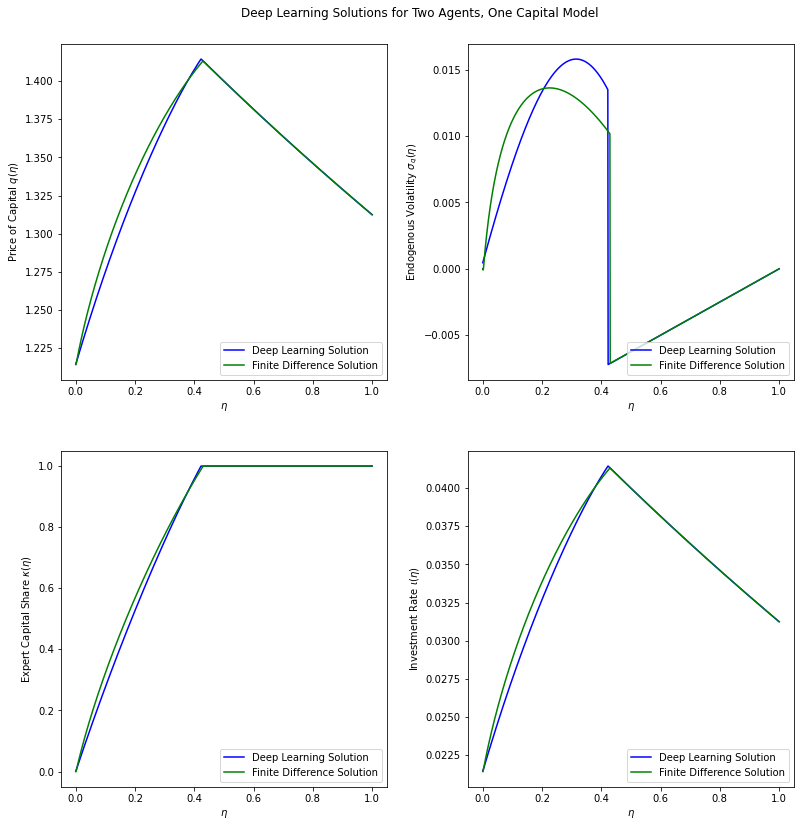

In [30]:
# verified results
#sns.set(style="whitegrid")
fig, axs = plt.subplots(2, 2, figsize=(12, 12))
fig.tight_layout(pad = 5.0)
axs = axs.flatten()
axs[0].plot(eta, q_merged, color="blue", label="Deep Learning Solution")
axs[0].plot(eta, q_merged_new, color="green", label="Finite Difference Solution")
axs[0].set_xlabel(r"$\eta$")
axs[0].set_ylabel(r"Price of Capital $q(\eta)$")
axs[0].legend(loc="lower right")
axs[1].plot(eta, sigma_q_merged, color="blue", label="Deep Learning Solution")
axs[1].plot(eta, sigma_q_merged_new, color="green", label="Finite Difference Solution")
axs[1].set_xlabel(r"$\eta$")
axs[1].set_ylabel("Endogenous Volatility $\sigma_q (\eta)$")
axs[1].legend(loc="lower right")
axs[2].plot(eta, kappa_merged, color="blue", label="Deep Learning Solution")
axs[2].plot(eta, kappa_merged_new, color="green", label="Finite Difference Solution")
axs[2].set_xlabel(r"$\eta$")
axs[2].set_ylabel(r"Expert Capital Share $\kappa (\eta)$")
axs[2].legend(loc="lower right")
axs[3].plot(eta, iota_merged, color="blue", label="Deep Learning Solution")
axs[3].plot(eta, iota_merged_new, color="green", label="Finite Difference Solution")
axs[3].set_xlabel(r"$\eta$")
axs[3].set_ylabel(r"Investment Rate $\iota (\eta)$")
axs[3].legend(loc="lower right")
plt.suptitle("Deep Learning Solutions for Two Agents, One Capital Model")
plt.show()